# Hotel Booking Cancellation Predictive Model


## Business Problem Understanding

### Context

Hotel A adalah sebuah jaringan hotel besar yang beroperasi di berbagai kota besar di Portugal. Sebagai bagian dari bisnisnya, hotel ini menerima ribuan reservasi setiap bulan. Namun, satu masalah besar yang mereka hadapi adalah tingginya tingkat pembatalan reservasi. Pembatalan reservasi menyebabkan berbagai masalah, termasuk: 
 - Kerugian Pendapatan
 - Perencanaan Operasional
 - Pengalaman Pelanggan

Target : 
 - 0 : Tidak ada pembatalan reservasi
 - 1 : Adanya Pembatalan reservasi

### Business Problem

Hotel A ingin mengurangi tingkat pembatalan reservasi untuk meningkatkan efisiensi operasional dan pendapatan. Mereka memutuskan untuk menggunakan pendekatan data-driven untuk memprediksi kemungkinan pembatalan reservasi di masa depan sehingga mereka dapat mengambil tindakan pencegahan lebih awal.

### Goals

- Memprediksi Pembatalan
- Mengoptimalkan Pendapatan
- Meningkatkan Perencanaan Operasional
- Meningkatkan Pengalaman Pelanggan

## 1. Data Collection / Data Understanding

Dataset Source : https://drive.google.com/drive/folders/17KIeOXK7eYGuzgpn_IljlUFcE4v96lSL

In [53]:
# Library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('Y:\TestPython\Purwadhika\DataFrame\DataSet\data_hotel_booking_demand.csv')
df.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


Features
- country: Country of origin.
- market_segment: Market segment designation. 
- previous_cancellations: Number of previous bookings that were cancelled by the customer prior to the current booking.
- booking_changes: Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation.
- deposit_type: Indication on if the customer made a deposit to guarantee the booking. 
- days_in_waiting_list: Number of days the booking was in the waiting list before it was confirmed to the customer.
- customer_type: Type of booking.
- reserved_room_type: Code of room type reserved. Code is presented instead of designation for anonymity reasons.
- required_car_parking_space: Number of car parking spaces required by the customer.
- total_of_special_request: Number of special requests made by the customer (e.g. twin bed or high floor).
- is_canceled: Value indicating if the booking was canceled (1) or not (0).


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83573 entries, 0 to 83572
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country                      83222 non-null  object
 1   market_segment               83573 non-null  object
 2   previous_cancellations       83573 non-null  int64 
 3   booking_changes              83573 non-null  int64 
 4   deposit_type                 83573 non-null  object
 5   days_in_waiting_list         83573 non-null  int64 
 6   customer_type                83573 non-null  object
 7   reserved_room_type           83573 non-null  object
 8   required_car_parking_spaces  83573 non-null  int64 
 9   total_of_special_requests    83573 non-null  int64 
 10  is_canceled                  83573 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 7.0+ MB


In [4]:
df.shape

(83573, 11)

In [5]:
display(df.describe(), df.describe(include='object'))

,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,is_canceled
count,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000
mean,0.086798,0.220897,2.330561,0.062999,0.573211,0.368277
std,0.841011,0.648635,17.673051,0.246919,0.795163,0.482340
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,26.000000,21.000000,391.000000,8.000000,5.000000,1.000000


,country,market_segment,deposit_type,customer_type,reserved_room_type
count,83222,83573,83573,83573,83573
unique,162,8,3,4,10
top,PRT,Online TA,No Deposit,Transient,A
freq,34097,39460,73352,62732,60041


In [6]:
missing_values_percentage = (df.isnull().sum() / len(df)) * 100
missing_values_percentage[missing_values_percentage > 0]

country    0.419992
dtype: float64

In [7]:
pd.set_option('display.max_colwidth', None)
# data uni di tiap kolom
listItem = []
for col in df.columns :
    listItem.append( [col, df[col].dtypes, df[col].nunique(), df[col].unique()])

tabel1Desc = pd.DataFrame(columns=['Column Name', 'Data Types', 'Number of Unique', 'Unique Sample'],
                     data=listItem)
tabel1Desc

,Column Name,Data Types,Number of Unique,Unique Sample
0,country,object,162,"[IRL, FRA, PRT, NLD, ESP, UMI, CN, LUX, BRA, BEL, JPN, DEU, ITA, CHE, GBR, AGO, SRB, COL, CHN, SWE, AUT, CIV, CZE, POL, USA, SGP, RUS, ROU, DNK, IND, MAR, PHL, ARG, ISL, ZAF, LBN, MOZ, TUR, BGD, MEX, CAF, NOR, FIN, UKR, EGY, ISR, nan, KOR, AZE, HUN, AUS, EST, CHL, SVN, PRY, ABW, ALB, LTU, ARE, HRV, SAU, NZL, LVA, ATA, KAZ, DZA, TWN, CRI, BIH, BGR, IRQ, OMN, VEN, IDN, GEO, MLT, IRN, BLR, URY, LBY, TUN, BEN, MYS, MWI, GRC, CYP, CPV, HKG, PRI, MKD, MUS, IMN, PAN, NGA, GLP, KHM, PER, QAT, SEN, MAC, ...]"
1,market_segment,object,8,"[Offline TA/TO, Online TA, Direct, Groups, Corporate, Complementary, Aviation, Undefined]"
2,previous_cancellations,int64,15,"[0, 1, 25, 2, 3, 11, 24, 13, 6, 26, 14, 4, 19, 5, 21]"
3,booking_changes,int64,19,"[0, 1, 2, 5, 3, 4, 6, 7, 9, 8, 17, 10, 13, 12, 14, 21, 16, 20, 15]"
4,deposit_type,object,3,"[No Deposit, Non Refund, Refundable]"
5,days_in_waiting_list,int64,115,"[0, 3, 39, 87, 77, 215, 97, 162, 46, 79, 4, 31, 122, 34, 57, 259, 50, 17, 32, 43, 75, 69, 44, 22, 113, 58, 38, 65, 48, 236, 176, 25, 108, 91, 19, 160, 68, 28, 63, 35, 42, 59, 24, 8, 183, 187, 21, 111, 56, 98, 101, 15, 16, 47, 93, 45, 14, 70, 10, 49, 178, 99, 60, 40, 85, 223, 6, 33, 391, 20, 1, 41, 147, 55, 80, 379, 150, 61, 330, 174, 107, 96, 18, 62, 13, 30, 120, 27, 207, 71, 2, 76, 125, 5, 9, 224, 53, 83, 84, 12, ...]"
6,customer_type,object,4,"[Transient-Party, Transient, Contract, Group]"
7,reserved_room_type,object,10,"[A, E, D, F, B, G, C, H, L, P]"
8,required_car_parking_spaces,int64,5,"[0, 1, 2, 8, 3]"
9,total_of_special_requests,int64,6,"[0, 2, 1, 3, 4, 5]"


Conclusion : 
 1. Terdapat __83.573__ entries dalam dataset ini.
 2. Terdapat 11 columns
 3. Missing Value hanya terdapat pada columns _country_

Feature (Numerical) Details :
 1. __Previous Cancellation__ : Rata-rata tamu melakukan pembatalan ialah 0.08 kali. Range data dalam columns ini berawal dari 0 ke 26.
 2. __booking changes__ : Booking mengalami perubahan dengan rata-rata 0.22 kali, dengan Range data dari 0 ke 21.
 3. __day in waiting list__ : Rata-rata booking tertahan di waiting list sekitar 2.33 hari dengan minimal 0 sampai 391 hari.
 4. __required_car_parking_spaces__ : Rata-rata tempat parkir mobil yang diminta oleh tamu ialah 0.06, dengan permintaan terbanyak ada di 8.
 5. __total_of_special_requests__ : Rata-rata permintaan special dari tamu ialah 0.57, dengan permintaan terbanyak adaa pada 5.
 6. __Is_Cancelled__ : Terdapt 2 unique values dengan 0 berarti tidak cancel dan 1 berarti canceled.

Feature (Categorical) Details :
 1. __Country__ : Terdapat 162 unique conutry code, dengan kemunculan tertinggi ialah PRT dengan 34097 kemunculan.
 2. __market_segment__ : Terdapat 8 unique values, dengan kemunculan terbanyak dengan 39460 kemunculan ialah Online TA.
 3. __deposit_type__ : Terdapat 3 unique values dengan No Deposit menjadi values paling sering muncul sebanyak 73352.
 4. __customer_type__ : Terdapat 4 kategori tamu, dengan kategori terbanyak ialah Transient dengan 62732
 5. __reserved_room_type__ : Terdapat 10 tipe kamar dengan pesanan terbanyak ialah kamar tipe A dengan 60041 pesanan.


## Data Preprocessing

In [8]:
high_cardinality_features = ['country', 'reserved_room_type', 'market_segment']
unique_categories = df[high_cardinality_features].nunique()
missing_values = df[high_cardinality_features].isnull().sum()

# Combine the two series into a single dataframe
high_cardinality_df = pd.DataFrame({'Unique_Categories': unique_categories, 'Missing_Values': missing_values})

high_cardinality_df

,Unique_Categories,Missing_Values
country,162,351
reserved_room_type,10,0
market_segment,8,0


### Country Feature

In [9]:
# Get unique values in the 'country' column
unique_values = df['country'].unique()
print(f"Unique values in 'country': {unique_values}")

# Get the counts of each unique value
value_counts = df['country'].value_counts()
print("Value counts for 'country':")
print(value_counts)


Unique values in 'country': ['IRL' 'FRA' 'PRT' 'NLD' 'ESP' 'UMI' 'CN' 'LUX' 'BRA' 'BEL' 'JPN' 'DEU'
 'ITA' 'CHE' 'GBR' 'AGO' 'SRB' 'COL' 'CHN' 'SWE' 'AUT' 'CIV' 'CZE' 'POL'
 'USA' 'SGP' 'RUS' 'ROU' 'DNK' 'IND' 'MAR' 'PHL' 'ARG' 'ISL' 'ZAF' 'LBN'
 'MOZ' 'TUR' 'BGD' 'MEX' 'CAF' 'NOR' 'FIN' 'UKR' 'EGY' 'ISR' nan 'KOR'
 'AZE' 'HUN' 'AUS' 'EST' 'CHL' 'SVN' 'PRY' 'ABW' 'ALB' 'LTU' 'ARE' 'HRV'
 'SAU' 'NZL' 'LVA' 'ATA' 'KAZ' 'DZA' 'TWN' 'CRI' 'BIH' 'BGR' 'IRQ' 'OMN'
 'VEN' 'IDN' 'GEO' 'MLT' 'IRN' 'BLR' 'URY' 'LBY' 'TUN' 'BEN' 'MYS' 'MWI'
 'GRC' 'CYP' 'CPV' 'HKG' 'PRI' 'MKD' 'MUS' 'IMN' 'PAN' 'NGA' 'GLP' 'KHM'
 'PER' 'QAT' 'SEN' 'MAC' 'SVK' 'BHR' 'ECU' 'SYC' 'BOL' 'TJK' 'LCA' 'MDV'
 'SYR' 'ZMB' 'LIE' 'THA' 'MNE' 'BRB' 'CMR' 'JEY' 'GTM' 'LKA' 'JOR' 'TZA'
 'AND' 'ARM' 'GIB' 'VNM' 'PAK' 'JAM' 'DOM' 'KWT' 'LAO' 'RWA' 'FRO' 'GAB'
 'ETH' 'CUB' 'COM' 'GNB' 'GGY' 'NIC' 'TGO' 'TMP' 'CYM' 'GHA' 'SLE' 'BWA'
 'NCL' 'UZB' 'SUR' 'SDN' 'PLW' 'MLI' 'MMR' 'BFA' 'SLV' 'BDI' 'ZWE' 'UGA'
 'DMA' 'VGB' 'KIR' 'KEN' '

In [10]:
# Handling Missing Value with Mode
mode_country = df['country'].mode()[0]
print(f"\nMode of 'country' column: {mode_country}")

# Fill missing values with the mode
df['country'].fillna(mode_country, inplace=True)


Mode of 'country' column: PRT


In [11]:
threshold = 5000  # Example threshold
value_counts = df['country'].value_counts()
to_combine = value_counts[value_counts < threshold].index
df['country'] = df['country'].replace(to_combine, 'Other')

Conclusion :
 - Handling missing value dengan mengisi missing value tersebut dengan mode
 - Menyederhanakan category dengan menyisakan top 5 frequent country dan lainnya digabung menjadi 'other'

### Reserved_room_type Feature

In [12]:
# Get unique values in the 'reserved_room_type' column
unique_values = df['reserved_room_type'].unique()
print(f"Unique values in 'reserved_room_type': {unique_values}")

# Get the counts of each unique value
value_counts = df['reserved_room_type'].value_counts()
print("Value counts for 'reserved_room_type':")
print(value_counts)


Unique values in 'reserved_room_type': ['A' 'E' 'D' 'F' 'B' 'G' 'C' 'H' 'L' 'P']
Value counts for 'reserved_room_type':
reserved_room_type
A    60041
D    13526
E     4649
F     2037
G     1447
B      787
C      673
H      401
P        9
L        3
Name: count, dtype: int64


In [13]:
# Mengahapus Category P dan L

df = df[~df['reserved_room_type'].isin(['P', 'L'])]

Conclusion :
 - Menyederhanakan category value, dengan menghilangkan category P dan L due to observasi yang sangat kecil
 - dan juga agar model yang dibuat nanti tidak mengalamai noise dan menambah complexity yang dapat mengarah ke overfitting

### Market_segment Feature

In [14]:
# Get unique values in the 'market_segment' column
unique_values = df['market_segment'].unique()
print(f"Unique values in 'market_segment': {unique_values}")

# Get the counts of each unique value
value_counts = df['market_segment'].value_counts()
print("Value counts for 'market_segment':")
print(value_counts)


Unique values in 'market_segment': ['Offline TA/TO' 'Online TA' 'Direct' 'Groups' 'Corporate' 'Complementary'
 'Aviation' 'Undefined']
Value counts for 'market_segment':
market_segment
Online TA        39458
Offline TA/TO    17024
Groups           13721
Direct            8895
Corporate         3791
Complementary      506
Aviation           165
Undefined            1
Name: count, dtype: int64


In [15]:
# Mengahapus Category Undefined

df = df[~df['market_segment'].isin(['Undefined'])]

Conclusion :
 - Menyederhanakan category value, dengan menghilangkan category Undefinef due to observasi yang sangat kecil yaitu 1
 - dan juga agar model yang dibuat nanti tidak mengalamai noise dan menambah complexity yang dapat mengarah ke overfitting

## Data Preparation

In [16]:
df.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,Other,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,Other,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


Tidak Perlu Encoding : 
    Data dalam features sudah memiliki nilai numerical, binary atau ordinal yang sudah berada dalam bentuk angka sehingga tidak perlu di encoding lagi.

- __previous_cancellations__ : Memiliki nilai numerical
- __booking_changes__ : Memiliki nilai Numerical
- __days_in_waiting_list__ : Memiliki nilai Numerical
- __required_car_parking_spaces__ : Memiliki nilai Numerical
- __total_of_special_requests__ : Memiliki nilai Numerical
- __is_canceled__ : Memiliki nilai binary dan merupakan target variable

One-Hot Encoding :
    Data dalam features dibawah memiliki nilai nominal dan harus dilakukan One-hot Encoding.

- __country__ : Memiliki nilai nominal
- __market_segment__ : Memiliki nilai nominal
- __deposit_type__ : Memiliki nilai nominal
- __customer_type__ : Memiliki nilai nominal
- __reserved_room_type__ : Memiliki nilai nominal

### Imbalanced Data

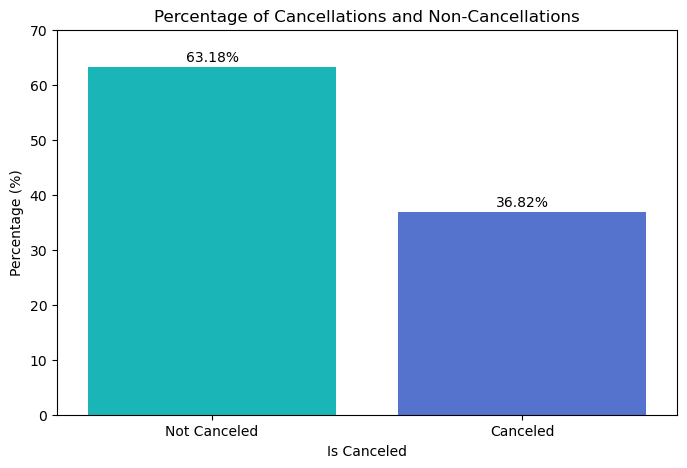

In [17]:
# Calculating the percentage of each class
percentage = df['is_canceled'].value_counts(normalize=True) * 100

# Plotting the percentage of each class
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=percentage.index, y=percentage, palette=['darkturquoise', 'royalblue'])
plt.title('Percentage of Cancellations and Non-Cancellations')
plt.xlabel('Is Canceled')
plt.ylabel('Percentage (%)')
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled'])
plt.yticks(ticks=range(0,80,10))

# Displaying the percentage on the bars
for i, p in enumerate(percentage):
    ax.text(i, p + 0.5, f'{p:.2f}%', ha='center', va='bottom')

plt.show()

Setelah kita mengecek keseimbangan dari data target variable, bisa dilihat bahwasannya data ini slightly imbalanced, karena kategory 'canceled' masih mewakili lebih dari 30% data.
Data dikatakan imbalanced apabila salah satu sangat mendominasi atau salah satu kategory hanya mewakili data dibawah 30%. 
Sehingga data ini hanya sedikit tidak seimbang, sehingga tidak perlu untuk di balancing.

### Modeling and Evaluation

In [18]:
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), ['country','market_segment', 'deposit_type', 'customer_type', 'reserved_room_type'])
], remainder='passthrough')

In [19]:
x = df.drop(columns=['is_canceled'])
y = df['is_canceled']

In [20]:
y.value_counts()

is_canceled
0    52793
1    30767
Name: count, dtype: int64

In [21]:
x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y,test_size=0.2,random_state=2021)

In [22]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()
lgbm = lgb.LGBMClassifier()

### Model Benchmarking : K-Fold

In [23]:
models = [logreg,knn,dt,rf,xgb,lgbm]
score=[]
rata=[]
std=[]

for i in models:
    skfold=StratifiedKFold(n_splits=5)
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    model_cv=cross_val_score(estimator,x_train,y_train,cv=skfold,scoring='roc_auc')
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'],'mean roc_auc':rata,'sdev':std}).set_index('model').sort_values(by='mean roc_auc',ascending=False)

[LightGBM] [Info] Number of positive: 19691, number of negative: 33787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 53478, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.368207 -> initscore=-0.539914
[LightGBM] [Info] Start training from score -0.539914
[LightGBM] [Info] Number of positive: 19691, number of negative: 33787
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 53478, number of used features: 28
[LightGBM] [Info] [b

,mean roc_auc,sdev
model,,
LightGBM,0.891174,0.001292
XGBoost,0.890999,0.001589
Random Forest,0.887410,0.001109
Decision Tree,0.883138,0.001085
Logistic Regression,0.860861,0.002057
KNN,0.850864,0.002976


Berdasarkan hasil dari model benchmarking di atas. LightGBM merupakan model terbaik untuk roc_aucnya yang menandakan performa yang sangat baik dan juga memiliki sdev yang rendah yang berarti model memberikan performa yang konsisten. 
Tetapi XGBoost juga memiliki nilai mean roc_auc dan sdev yang mirip dengan LGBM, sehingga keduanya masih memiliki nilai yang sama.

### Model Benchmarking : Test Data

In [24]:
models = [logreg,knn,dt,rf,xgb,lgbm]
score_roc_auc = []

def y_pred_func(i):
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    x_train,x_test
    
    estimator.fit(x_train,y_train)
    return(estimator,estimator.predict(x_test),x_test)

for i,j in zip(models, ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost','LightGBM']):
    estimator,y_pred,x_test = y_pred_func(i)
    y_predict_proba = estimator.predict_proba(x_test)[:,1]
    score_roc_auc.append(roc_auc_score(y_test,y_predict_proba))
    print(j,'\n', classification_report(y_test,y_pred))
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost','LightGBM'],
             'roc_auc score':score_roc_auc}).set_index('model').sort_values(by='roc_auc score',ascending=False)

Logistic Regression 
               precision    recall  f1-score   support

           0       0.77      0.92      0.84     10559
           1       0.80      0.54      0.64      6153

    accuracy                           0.78     16712
   macro avg       0.79      0.73      0.74     16712
weighted avg       0.78      0.78      0.77     16712

KNN 
               precision    recall  f1-score   support

           0       0.77      0.85      0.81     10559
           1       0.69      0.57      0.63      6153

    accuracy                           0.75     16712
   macro avg       0.73      0.71      0.72     16712
weighted avg       0.74      0.75      0.74     16712

Decision Tree 
               precision    recall  f1-score   support

           0       0.82      0.89      0.85     10559
           1       0.77      0.68      0.72      6153

    accuracy                           0.81     16712
   macro avg       0.80      0.78      0.79     16712
weighted avg       0.81      0

,roc_auc score
model,
LightGBM,0.890362
XGBoost,0.890336
Random Forest,0.885781
Decision Tree,0.881934
Logistic Regression,0.859779
KNN,0.826070


Pada test data ini, LightGBM kembali menjadi model yang paling bagus performanya. Dan memiliki selisih yang sangat kecil dengan XGBoost.

## XGBoost 

Bussines Problem Understanding

Dalam membuat sebuah predictive model untuk memprediksi masalah pada booking hotel, target variable yang digunakan ialah 'is_canceled'
 - 0 : Reservasi tidak dibatalkan
 - 1 : Reservasi dibatalkan

Dan juga dalam melakukan prediksi, model tidak luput dalam melakukan kesalahan
 - False Positive : Model memprediksi reservasi dibatalkan padahal sebenarnya tidak
 - False Negative : Model memprediksi reservasi tidak dibatalkan padahal sebenarnya dibatalkan
Kedua, kesalahan prediksi ini akan sangat berpengaruh terhadap cost dari hotel tersebut.

Terdapat 3 pendekatan matric yang bisa digunakan, 
1. Recall : Dengan memaksimalkan nilai recall untuk class (1) akan sangat membantu model untuk meminimalisir false negative. False negative memiliki pengaruh yang sangat besar bagi hotel karena, hotel bisa saja kehilangan banyak tamu karena kamar sudah penuh semuanya, padahal sebenarnya ada banyak kamar kosong karena adanya pembatalan reservasi. 
2. Precision : Dengan memaksimalkan nilai precision untuk class (1) akan sangat membantu model untuk menimalisir false positive, dimana model memprediksi adanya pembatalan reservasi padahal tidak ada. Ini dapat menimbulkan banyak masalah dengan tamu miss komunikasi dan ketidakpuasan tamu terhadap pelayanan hotel.
3. F1-Score : matric ini merupakan matric yang sangat sempurna untuk project ini karena ia penyeimbang diantara precision dan recall, yang merupakan matric yang sangat dibutuhkan. Lebih detail lagi, melihat F1-Score khusus untuk class (1) akan sangat berguna untuk mendapatkan conclusi yang maksimal dalam project ini. 




In [36]:
# One-hot encode the specified columns
one_hot_cols = ['country','market_segment', 'deposit_type', 'customer_type', 'reserved_room_type']
df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83560 entries, 0 to 83572
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   previous_cancellations         83560 non-null  int64
 1   booking_changes                83560 non-null  int64
 2   days_in_waiting_list           83560 non-null  int64
 3   required_car_parking_spaces    83560 non-null  int64
 4   total_of_special_requests      83560 non-null  int64
 5   is_canceled                    83560 non-null  int64
 6   country_ESP                    83560 non-null  bool 
 7   country_FRA                    83560 non-null  bool 
 8   country_GBR                    83560 non-null  bool 
 9   country_Other                  83560 non-null  bool 
 10  country_PRT                    83560 non-null  bool 
 11  market_segment_Complementary   83560 non-null  bool 
 12  market_segment_Corporate       83560 non-null  bool 
 13  market_segment_Direct

### Data Splitting

In [43]:
X = df.drop('is_canceled', axis=1)
y = df['is_canceled'] 

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.2,random_state=2021)

### Function

In [59]:
def tune_clf_hyperparameters(clf, param_grid, X_train, y_train, scoring='f1', n_splits=5):
    '''
    This function optimizes the hyperparameters for a classifier by searching over a specified hyperparameter grid. 
    It uses GridSearchCV and cross-validation (StratifiedKFold) to evaluate different combinations of hyperparameters. 
    The combination with the highest F1-score for class 1 (canceled bookings) is selected as the default scoring metric. 
    The function returns the classifier with the optimal hyperparameters.
    '''
    
    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2021)

    # Create the GridSearchCV object
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=scoring, n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    best_hyperparameters = clf_grid.best_params_
    
    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_, best_hyperparameters

In [60]:
def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name):
    '''
    This function provides a complete report of the model's performance including classification reports, 
    confusion matrix and ROC curve.
    '''
    sns.set(font_scale=1.2)
    
    # Generate classification report for training set
    y_pred_train = clf.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Generate classification report for test set
    y_pred_test = clf.predict(X_test)
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    
    # Create figure and subplots 
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=100, gridspec_kw={'width_ratios': [2, 2, 1]})
    
    # Define a colormap
    royalblue = LinearSegmentedColormap.from_list('royalblue', [(0, (1,1,1)), (1, (0.25,0.41,0.88))])
    royalblue_r = royalblue.reversed()

    # Plot confusion matrix for test set
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False, cmap=royalblue_r, ax=ax1)
    ax1.set_title('Confusion Matrix for Test Data')                                     
    ax1.grid(False)
    
    # Plot ROC curve for test data and display AUC score 
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax2)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve for Test Data (Positive label: 1)')
    
    # Report results for the class specified by positive label
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax3.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 2)
    table.set_fontsize(12)
    ax3.axis('tight')
    ax3.axis('off')
    # Modify color 
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color('royalblue')
    plt.tight_layout()
    plt.show() 

In [61]:
def metrics_calculator(clf, X_test, y_test, model_name):
    '''
    This function calculates all desired performance metrics for a given model on test data.
    The metrics are calculated specifically for class 1.
    '''
    y_pred = clf.predict(X_test)
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, pos_label=1),
                                recall_score(y_test, y_pred, pos_label=1),
                                f1_score(y_test, y_pred, pos_label=1),
                                roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])],
                          index=['Accuracy','Precision (Class 1)','Recall (Class 1)','F1-score (Class 1)','AUC (Class 1)'],
                          columns = [model_name])
    
    result = (result * 100).round(2).astype(str) + '%'                            
    return result

### Base Model XGBoost

In [62]:
xgb_base = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=2021)

### Hyperparameter Tuning

In [63]:
# Define the parameter grid
param_grid_xgb = {
    'n_estimators': [250, 350],
    'learning_rate': [0.01, 0.1],
    'max_depth': [7, 8],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.8, 0.9],
    'scale_pos_weight': [1, (y_train == 0).sum() / (y_train == 1).sum()]
}

In [64]:
# Call the function for hyperparameter tuning
best_xgb, best_xgb_hyperparams = tune_clf_hyperparameters(xgb_base, param_grid_xgb, X_train, y_train)

In [65]:
print('XGBoost Optimal Hyperparameters: \n', best_xgb_hyperparams)

XGBoost Optimal Hyperparameters: 
 {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 250, 'scale_pos_weight': 1.7158527667181278, 'subsample': 0.8}


- Colsample_bytree : Value 0.8 menandakan bahwa 80% dari features akan di sample secara acak untuk setiap tree.
- learning_rate : Semakin kecil valuenya makin membuat modelnya robust tapi membutuhkan lebih banyak boosting rounds.
- max_depth : Parameter ini menunjukkan kedalaman maksimal dari sebuah tree. 
- n_estimator : Menunjukkan boosting rounds atau tree yang diperlukan untuk membuat model.
- scale_post_weight : Parameter ini spesifik untuk XGBoost untuk tugas klasifikasi biner dan control keseimbangan untuk class positive dan negative.
- subsample : Value 0.8 menandakan bahwa 80% dari data training akan dimanfaatkan untuk setiap boosting round.

### XGBoost Feature Importance

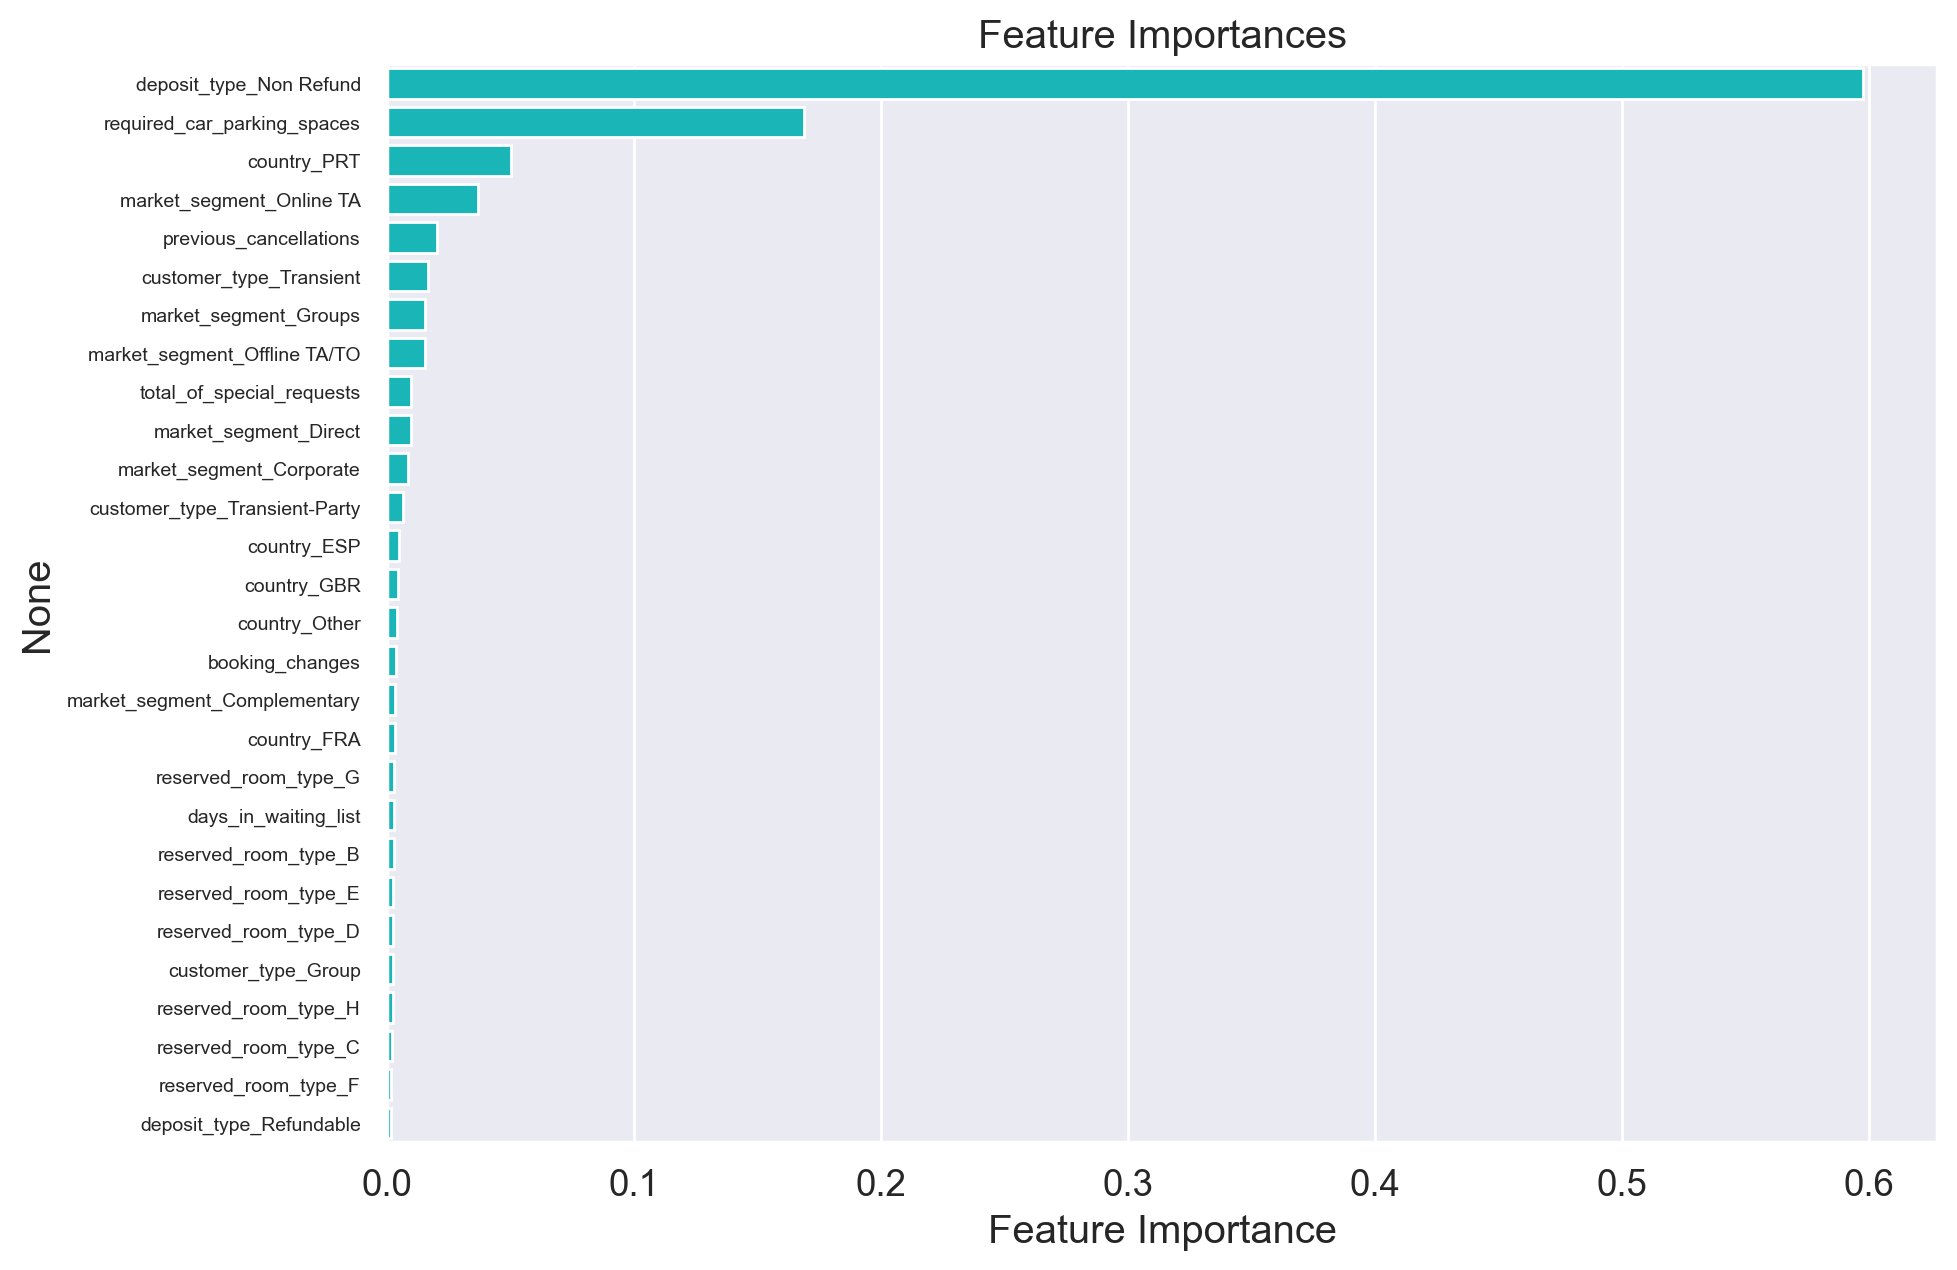

In [67]:
# Compute feature importances
feature_importances = best_xgb.feature_importances_

# Sort the feature importances in descending order and get the indices
sorted_indices = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 7), dpi=200)
sns.barplot(x=feature_importances[sorted_indices], y=X.columns[sorted_indices], color='darkturquoise')
plt.xlabel('Feature Importance')
plt.title('Feature Importances')
plt.yticks(fontsize=7)
plt.show()

### XGBoost Result


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.82      0.84     42234
           1       0.71      0.78      0.75     24614

    accuracy                           0.81     66848
   macro avg       0.79      0.80      0.79     66848
weighted avg       0.81      0.81      0.81     66848


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.81      0.84     10559
           1       0.71      0.78      0.74      6153

    accuracy                           0.80     16712
   macro avg       0.79      0.80      0.79     16712
weighted avg       0.81      0.80      0.80     16712



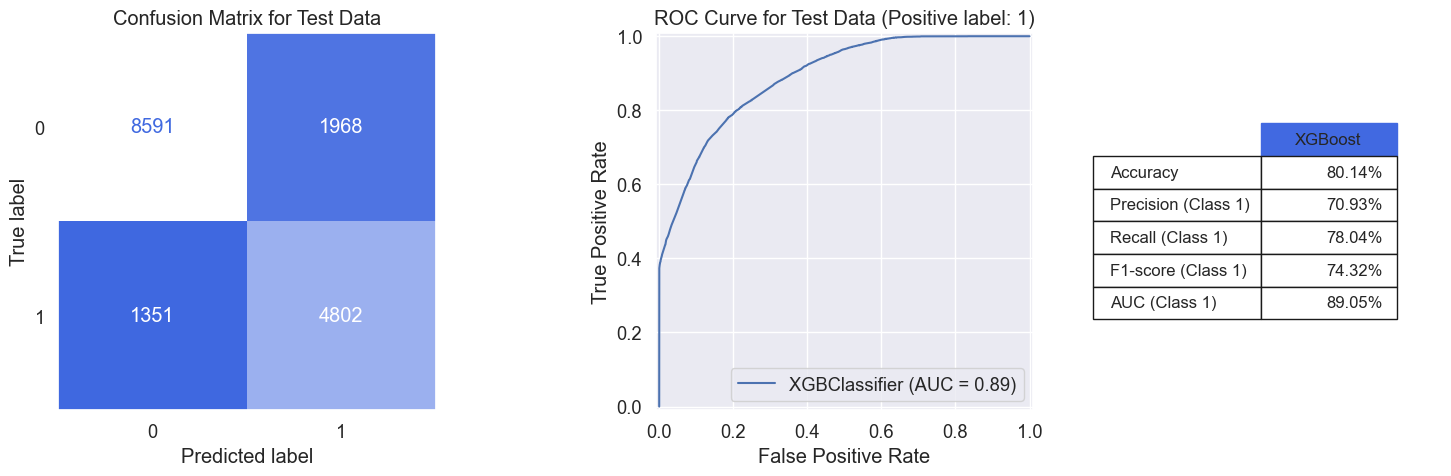

In [68]:
model_evaluation(best_xgb, X_train, X_test, y_train, y_test, 'XGBoost')

1.  Precision : Dari semua prediksi untuk class (1), model berhasil untuk memprediksi sebanyak 71% dari pembatalan reservasi yang benar melakukan pembatalan. Dan hanya menyisakan 30% kebawah ruang untuk model masih mungkin untuk melakukan kesalahan prediksi. Hal ini sudah sangat baik dimana berarti hotel dapat meminimalisir permasalahan yang mungkin timbul dari false positive sebanyak 71%.
2. Recall : Dari semua prediksi untuk class (1), model berhasil untuk memprediksi sebanyak 78% dimana reservasi benar tidak dibatalkan. Dan hanya tersisa 20% ruang untuk adanya false negative. Hal ini dapat membantu hotel untuk dapat merencakan tindakan awal untuk mencegah kehilangan banyak tamu karena tidak adanya kamar yang kosong karena overbooking.
3. F1-Score : Dengan melihat value dari F1-Score untuk class (1 / canceled). Value yang tinggi dari F1-Score menandakan keseimbangan diantara memperkecil cost untuk false negative dan false positive, dimana hal ini merupakan hal yang sangat berpengaruh terhadap hotel untuk mengoptimalkan kesediaan kamar dan meminimalisir overbooking dan ketidakpuasan tamu. 

Contoh Implementasi Lapangan : 
    Misal harga booking 1 kamar : 100$

Tanpa Model :
 - Ekspektasi Total Pemasukan : 100 * 100$ = 10000$
 - Total pemasukan sebenarnya : 22 * 100$ = 2200$ (False Negative)
 - Kerugian : 7800$

Dengan Model : 
 - Ekspektasi Total Pemasukan : 100 * 100$ = 10000$
 - Total pemasukan sebenarnya : 78 * 100$ = 7800$
 - Kerugian : 2200$

Bersarakan contoh perhitungan diatas, maka estimasi kerugian yang mungkin akan dialami oleh hotel dapat berkurang drastis dengan model yang kita jalankan.